In [1]:
# ENSEMBLE LGBM with Catboost

## Library

In [2]:
! pip install pycld2

     |████████████████████████████████| 41.4 MB 159 kB/s            
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9917820 sha256=3f0e920d269580398fe568f85f834ef8e586cf70b77d733fd3b73871d57e4458
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


In [3]:
# library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# sklearn
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# models
import lightgbm as lgb
from catboost import Pool
import catboost as cb
import xgboost as xgb

# others
from tqdm import tqdm_notebook as tqdm

from gensim.models import word2vec, KeyedVectors
import pycld2 as cld2

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout,Concatenate,Lambda,GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

## Config

In [4]:
# Config
SEED = 1010
SHUFFLE = True
N_SPLITS = 5
TRAIN = True
ENSEMBLE = True
# ENSEMBLE = False


EXP = '001'

# Model 
CATBOOST = True
XGBOOST = True


## LGBM 
LGBM_PARAMS = {
    'num_leaves': 300,
    'max_bin':450,
    'objective': 'binary',
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'metric':"binary_logloss",
    'verbose': -1

}
LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

## Catboost
CAT_PARAMS = {
    'early_stopping_rounds' : 50,
    'depth' : 6,  
    'learning_rate': 0.05,
    'iterations' : 5000, 
    'custom_loss' :['Logloss'], 
    'use_best_model':True, 
    'random_seed' :SEED
}

## xgboost
XGB_PARAMS = {
    'colsample_bytree': 0.8,                 
    'learning_rate': 0.003,
    'max_depth': 31,
    'subsample': 1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'min_child_weight':3,
    'gamma':0.25,
    'n_estimators':5000,
    'verbosity':0
}
XGB_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

# SEED
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEED)

## Function

### lgbm

In [5]:
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        #feature_name=feature_name
                        )

    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            #feature_name=feature_name
                            )

    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
#         print(y_valid)
#         print(y_pred_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
        print('valid_loss: ', valid_loss)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

### catboost

In [6]:
def train_catboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, cat_params,loss_func, calc_importances=False):

    train = Pool(X_train, y_train)
    if X_valid is not None:
        valid = Pool(X_valid, y_valid)
    if X_valid is not None:
        model = cb.CatBoostClassifier(**cat_params)
        model.fit(train, eval_set=valid, verbose=False)
#         model = cb.CatBoost()
#         model.fit(train, eval_set=valid, verbose=False, **cat_params)
    else:
        model = cb.CatBoostClassifier(**cat_params)
        model.fit(train, verbose=False)

    # train score
    if X_valid is not None:
#         y_pred_valid = model.predict(X_valid)
        y_pred_valid = model.predict_proba(X_valid)[:,1]
#         print(y_valid)
#         print(y_pred_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
        print('valid_loss: ', valid_loss)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
#         y_pred_test = model.predict(X_test)
        y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None
        
    print('get_best_iteration: ', model.get_best_iteration())

    return y_pred_valid, y_pred_test, valid_loss, importances, model.get_best_iteration(), model

### xgboost

In [7]:
def train_xgboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, xgb_params, fit_params, loss_func, calc_importances=False):

    train = xgb.DMatrix(X_train, y_train)
    X_test = xgb.DMatrix(X_test)
    
    if X_valid is not None:
        valid = xgb.DMatrix(X_valid, y_valid)
    if X_valid is not None:
        model = xgb.train(
            xgb_params,
            train,
            evals=[(train, 'train'), (valid, 'val')],
            **fit_params
        )
        
    else:
        model = xgb.train(
            xgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(valid)
#         y_pred_valid = model.predict_proba(X_valid)[:,1]
        valid_loss = loss_func(y_valid, y_pred_valid)
        print('valid_loss: ', valid_loss)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
#         y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

In [8]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FGRatioW':'FGRatioA',
        'FG3RatioW':'FG3RatioA',
        'FTRatioW':'FTRatioA',
        'eFGW':'eFGA',
        'TO%W':'TO%A',
        'FTRW':'FTRA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLossesW':'NumLossesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FGRatioL':'FGRatioB',
        'FG3RatioL':'FG3RatioB',
        'FTRatioL':'FTRatioB',
        'eFGL':'eFGB',
        'TO%L':'TO%B',
        'FTRL':'FTRB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLossesL':'NumLossesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FGRatioW':'FGRatioB',
        'FG3RatioW':'FG3RatioB',
        'FTRatioW':'FTRatioB',
        'eFGW':'eFGB',
        'TO%W':'TO%B',
        'FTRW':'FTRB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLossesW':'NumLossesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FGRatioL':'FGRatioA',
        'FG3RatioL':'FG3RatioA',
        'FTRatioL':'FTRatioA',
        'eFGL':'eFGA',
        'TO%L':'TO%A',
        'FTRL':'FTRA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLossesL':'NumLossesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [9]:
# Loss
def calc_loss(y_true, y_pred):
    return  log_loss(y_true, y_pred)

# Reading data

In [10]:
flist = os.listdir('../input/womens-march-mania-2022/WDataFiles_Stage1')
print(len(flist))
flist

14


['Conferences.csv',
 'WNCAATourneyDetailedResults.csv',
 'WSampleSubmissionStage1.csv',
 'WRegularSeasonCompactResults.csv',
 'WGameCities.csv',
 'WNCAATourneySlots.csv',
 'Cities.csv',
 'WTeams.csv',
 'WNCAATourneyCompactResults.csv',
 'WSeasons.csv',
 'WNCAATourneySeeds.csv',
 'WRegularSeasonDetailedResults.csv',
 'WTeamSpellings.csv',
 'WTeamConferences.csv']

In [11]:
# datasets_path = './ncaam-march-mania-2021/MDataFiles_Stage2/'
datasets_path = '../input/womens-march-mania-2022/WDataFiles_Stage1/'
SAVE_TEST_SUB_PATH = f"exp{EXP}_submission.csv"
# SUB_PATH = datasets_path + 'WSampleSubmissionStage2.csv'
SUB_PATH = datasets_path + 'WSampleSubmissionStage1.csv'

In [12]:
# ordinals = pd.read_csv(datasets_path + 'WMasseyOrdinals.csv').rename(columns={'RankingDayNum':'DayNum'})
# ordinals.head()

In [13]:
seeds = pd.read_csv(datasets_path + 'WNCAATourneySeeds.csv')
seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [14]:
regular_result = pd.read_csv(datasets_path + 'WRegularSeasonDetailedResults.csv')
regular_result

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63882,2022,98,3359,73,3190,61,H,0,27,60,5,19,14,17,10,29,18,17,6,4,16,23,60,4,16,11,17,7,21,11,10,8,3,17
63883,2022,98,3360,81,3334,77,A,0,25,56,9,25,22,29,10,25,13,19,9,0,24,25,57,8,25,19,26,9,21,19,18,5,1,26
63884,2022,98,3379,60,3427,57,H,1,23,65,3,9,11,22,16,21,16,19,9,8,14,23,68,3,17,8,15,17,22,15,21,9,6,18
63885,2022,98,3388,88,3365,81,A,0,28,54,6,15,26,30,7,30,16,12,4,1,20,27,63,10,23,17,24,11,21,19,10,5,4,22


## Preprocessing, FE

In [15]:
# ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
# ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
# ordinals['Rating']= 100-4*np.log(ordinals['OrdinalRank']+1)-ordinals['OrdinalRank']/22

# ordinals

In [16]:
num_win = regular_result.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_win

,Season,TeamID,NumWins
0,2010,3102,1
1,2010,3103,17
2,2010,3104,11
3,2010,3105,14
4,2010,3106,12
...,...,...,...
4494,2022,3468,1
4495,2022,3469,3
4496,2022,3470,8
4497,2022,3471,8


In [17]:
num_loss = regular_result.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
num_loss

,Season,TeamID,NumLosses
0,2010,3102,27
1,2010,3103,13
2,2010,3104,18
3,2010,3105,13
4,2010,3106,17
...,...,...,...
4505,2022,3468,18
4506,2022,3469,14
4507,2022,3470,10
4508,2022,3471,10


In [18]:
wl = pd.merge(num_win, num_loss, how='left', on=['Season', 'TeamID']).reset_index(drop=True)
wl

,Season,TeamID,NumWins,NumLosses
0,2010,3102,1,27.0
1,2010,3103,17,13.0
2,2010,3104,11,18.0
3,2010,3105,14,13.0
4,2010,3106,12,17.0
...,...,...,...,...
4494,2022,3468,1,18.0
4495,2022,3469,3,14.0
4496,2022,3470,8,10.0
4497,2022,3471,8,10.0


In [19]:
wteam_stats = regular_result.groupby(['Season', 'WTeamID']).mean().reset_index()
wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3',
'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
], axis=1, inplace=True)
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2010,3102,68.000000,48.000000,23.000000,51.000000,6.000000,14.000000,16.000000,21.000000,11.000000,29.000000,13.000000,14.000000,9.000000,1.000000,10.000000
1,2010,3103,66.352941,53.176471,23.941176,56.000000,4.352941,12.235294,14.117647,19.823529,14.176471,25.764706,14.235294,16.882353,8.705882,2.705882,16.058824
2,2010,3104,72.818182,57.454545,28.000000,59.545455,4.818182,13.636364,12.000000,19.636364,14.363636,28.000000,17.181818,20.545455,8.454545,3.000000,18.454545
3,2010,3105,66.428571,59.071429,21.785714,47.571429,3.142857,8.357143,19.714286,26.500000,11.285714,25.571429,11.285714,25.714286,8.928571,5.642857,18.714286
4,2010,3106,59.833333,51.333333,19.583333,49.833333,2.250000,7.000000,18.416667,28.166667,14.916667,25.583333,12.166667,19.250000,7.500000,5.333333,21.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494,2022,3468,68.000000,61.000000,25.000000,54.000000,8.000000,20.000000,10.000000,14.000000,7.000000,21.000000,13.000000,14.000000,6.000000,2.000000,13.000000
4495,2022,3469,71.333333,62.666667,25.333333,56.333333,9.333333,24.666667,11.333333,14.000000,8.666667,30.666667,12.333333,18.666667,6.000000,3.000000,13.666667
4496,2022,3470,59.375000,53.625000,21.625000,52.125000,4.500000,12.750000,11.625000,16.375000,9.000000,24.000000,11.375000,18.625000,7.750000,5.875000,12.500000
4497,2022,3471,67.375000,56.750000,23.875000,61.375000,9.875000,27.625000,9.750000,12.000000,8.250000,29.125000,16.250000,12.250000,5.500000,3.000000,15.875000


In [20]:
lteam_stats = regular_result.groupby(['Season', 'LTeamID']).mean().reset_index()
lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3',
'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
], axis=1, inplace=True)
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2010,3102,72.666667,51.222222,19.000000,53.222222,4.518519,16.148148,8.703704,12.925926,12.518519,19.185185,10.148148,17.851852,5.925926,0.629630,15.148148
1,2010,3103,68.076923,56.846154,20.000000,54.307692,3.384615,12.769231,13.461538,19.307692,14.230769,20.692308,12.384615,20.076923,7.153846,2.000000,19.461538
2,2010,3104,72.833333,58.833333,22.722222,63.666667,4.055556,15.388889,9.333333,15.055556,14.555556,24.666667,10.611111,18.333333,6.722222,2.888889,21.611111
3,2010,3105,70.846154,54.692308,18.846154,54.384615,2.923077,11.538462,14.076923,22.000000,16.230769,21.000000,8.076923,24.307692,8.615385,4.615385,19.615385
4,2010,3106,61.705882,51.823529,17.647059,55.235294,3.000000,11.411765,13.529412,21.058824,15.058824,24.176471,11.000000,20.705882,8.411765,3.882353,22.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4505,2022,3468,76.277778,56.333333,20.666667,59.000000,6.000000,20.000000,9.000000,13.000000,8.833333,20.333333,10.777778,18.666667,6.833333,3.000000,18.444444
4506,2022,3469,77.785714,57.785714,20.785714,57.357143,7.857143,28.642857,8.357143,12.071429,5.857143,24.714286,12.071429,15.857143,4.857143,2.642857,15.857143
4507,2022,3470,64.500000,49.200000,17.900000,53.600000,4.500000,16.700000,8.900000,13.200000,8.400000,21.300000,8.900000,16.000000,7.300000,3.500000,16.000000
4508,2022,3471,63.800000,51.100000,18.800000,57.700000,6.300000,23.700000,7.200000,10.400000,9.200000,23.700000,11.200000,17.200000,5.600000,4.500000,17.400000


In [21]:
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()

# Score-gab
regular_season_feature['Scoregap'] = regular_season_feature['Score'] -regular_season_feature['Scored']
# FGM/FGA
regular_season_feature['FGRatio'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# FGM3/FGA3
regular_season_feature['FG3Ratio'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FTM/FTA
regular_season_feature['FTRatio'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value)
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FGRatio']+regular_season_feature['FGM3']*regular_season_feature['FG3Ratio']+regular_season_feature['FTM']*regular_season_feature['FTRatio']
# TR
regular_season_feature['TR'] = regular_season_feature['OR']+regular_season_feature['DR']
# TS%
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA']))

# Four-Factor
regular_season_feature['eFG'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']

regular_season_feature['TO%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

regular_season_feature['FTR'] = regular_season_feature['FTA']/regular_season_feature['FGA']

# PPP/POSS
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO']

regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Losses
regular_season_feature = regular_season_feature.merge(wl, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins']+regular_season_feature['NumLosses'])

#regular_season_feature.drop(['Score'], axis=1, inplace=True)
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Scoregap,FGRatio,FG3Ratio,FTRatio,EV,TR,TS%,eFG,OR%,TO%,FTR,POSS,PPP,NumWins,NumLosses,WinRatio
0,2010,3102,59.611111,60.333333,21.000000,52.111111,5.259259,15.074074,12.351852,16.962963,11.759259,24.092593,11.574074,15.925926,7.462963,0.814815,12.574074,-0.722222,0.402985,0.348894,0.728166,19.291810,35.851852,0.500305,0.453447,0.225657,0.210937,0.325515,75.500741,0.789543,1.0,27.0,0.035714
1,2010,3103,61.599548,60.626697,21.970588,55.153846,3.868778,12.502262,13.789593,19.565611,14.203620,23.228507,13.309955,18.479638,7.929864,2.352941,17.760181,0.972851,0.398351,0.309446,0.704787,19.667913,37.432127,0.483037,0.433424,0.257527,0.224697,0.354746,82.242353,0.749000,17.0,13.0,0.566667
2,2010,3104,65.825758,65.143939,25.361111,61.606061,4.436869,14.512626,10.666667,17.345960,14.459596,26.333333,13.896465,19.439394,7.588384,2.944444,20.032828,0.681818,0.411666,0.305725,0.614937,18.356088,40.792929,0.475357,0.447676,0.234711,0.219214,0.281563,88.677677,0.742304,11.0,18.0,0.379310
3,2010,3105,60.560440,64.958791,20.315934,50.978022,3.032967,9.947802,16.895604,24.250000,13.758242,23.285714,9.681319,25.010989,8.771978,5.129121,19.164835,-4.398352,0.398523,0.304888,0.696726,20.792697,37.043956,0.491179,0.428271,0.269886,0.288614,0.475695,86.659011,0.698836,14.0,13.0,0.518519
4,2010,3106,55.828431,56.519608,18.615196,52.534314,2.625000,9.205882,15.973039,24.612745,14.987745,24.879902,11.583333,19.977941,7.955882,4.607843,22.022059,-0.691176,0.354344,0.285144,0.648974,17.710769,39.867647,0.440538,0.379327,0.285294,0.239711,0.468508,83.341863,0.669873,12.0,17.0,0.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,2022,3468,62.166667,68.638889,22.833333,56.500000,7.000000,20.000000,9.500000,13.500000,7.916667,20.666667,11.888889,16.333333,6.416667,2.500000,15.722222,-6.472222,0.404130,0.350000,0.703704,18.362815,28.583333,0.497811,0.466077,0.140118,0.207346,0.238938,78.773333,0.789184,1.0,18.0,0.052632
4515,2022,3469,64.559524,70.226190,23.059524,56.845238,8.595238,26.654762,9.845238,13.035714,7.261905,27.690476,12.202381,17.261905,5.428571,2.821429,14.761905,-5.666667,0.405654,0.322465,0.755251,19.561493,34.952381,0.515808,0.481257,0.127749,0.216198,0.229319,79.842857,0.808582,3.0,14.0,0.176471
4516,2022,3470,54.287500,59.062500,19.762500,52.862500,4.500000,14.725000,10.262500,14.787500,8.700000,22.650000,10.137500,17.312500,7.525000,4.687500,14.250000,-4.775000,0.373847,0.305603,0.693998,15.885526,31.350000,0.457204,0.416410,0.164578,0.225772,0.279735,76.681500,0.707961,8.0,10.0,0.444444
4517,2022,3471,59.237500,60.275000,21.337500,59.537500,8.087500,25.662500,8.475000,11.200000,8.725000,26.412500,13.725000,14.725000,5.550000,3.750000,16.637500,-1.037500,0.358388,0.315149,0.756696,16.608861,35.137500,0.459451,0.426307,0.146546,0.185944,0.188117,79.190500,0.748038,8.0,10.0,0.444444


In [22]:
tourney_results = pd.read_csv(datasets_path + 'WNCAATourneyCompactResults.csv')
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,138,3130,73,3330,72,A,0
1,2003,138,3160,84,3140,45,H,0
2,2003,138,3208,80,3150,61,H,0
3,2003,138,3261,86,3402,50,N,0
4,2003,138,3278,68,3408,48,N,0
...,...,...,...,...,...,...,...,...
1129,2021,148,3376,62,3400,34,N,0
1130,2021,148,3390,78,3257,63,N,0
1131,2021,151,3112,69,3163,59,N,0
1132,2021,151,3390,66,3376,65,N,0


In [23]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsW', 'NumLosses':'NumLossesW', 'WinRatio': 'WinRatioW',
    'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW','OR':'ORW',
    'DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
    'FGRatio':'FGRatioW','FG3Ratio':'FG3RatioW','FTRatio':'FTRatioW','eFG':'eFGW','TO%':'TO%W','FTR':'FTRW',
    'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W','Score':'ScoreW',
    'Scored':'ScoredW','Scoregap':'ScoregapW'
}).drop(columns='TeamID', axis=1)

# tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FGRatioW,FG3RatioW,FTRatioW,EVW,TRW,TS%W,eFGW,OR%W,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW
0,2003,138,3130,73,3330,72,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,138,3160,84,3140,45,H,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,138,3208,80,3150,61,H,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,138,3261,86,3402,50,N,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,138,3278,68,3408,48,N,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,2021,148,3376,62,3400,34,N,0,68.806818,61.329545,26.602273,67.318182,3.715909,13.534091,11.886364,18.261364,14.238636,28.7500,11.636364,14.340909,6.590909,6.534091,12.295455,7.477273,0.395172,0.274559,0.650902,19.269577,42.988636,0.456562,0.422772,0.211512,0.159887,0.271269,89.694091,0.767128,22.0,4.0,0.846154
1130,2021,148,3390,78,3257,63,N,0,74.100000,62.290000,29.160000,63.210000,6.230000,19.880000,9.550000,14.100000,11.010000,26.7800,14.280000,12.310000,8.320000,6.240000,15.580000,11.810000,0.461319,0.313380,0.677305,21.872696,37.790000,0.533754,0.510600,0.174181,0.150629,0.223066,81.724000,0.906710,25.0,2.0,0.925926
1131,2021,151,3112,69,3163,59,N,0,63.212500,60.018750,22.925000,60.106250,5.568750,18.337500,11.793750,16.512500,8.912500,24.3375,10.131250,12.593750,9.862500,4.200000,14.831250,3.193750,0.381408,0.303681,0.714232,18.858370,33.250000,0.469132,0.427732,0.148279,0.157490,0.274722,79.965500,0.790497,16.0,5.0,0.761905
1132,2021,151,3390,66,3376,65,N,0,74.100000,62.290000,29.160000,63.210000,6.230000,19.880000,9.550000,14.100000,11.010000,26.7800,14.280000,12.310000,8.320000,6.240000,15.580000,11.810000,0.461319,0.313380,0.677305,21.872696,37.790000,0.533754,0.510600,0.174181,0.150629,0.223066,81.724000,0.906710,25.0,2.0,0.925926


In [24]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsL', 'NumLosses':'NumLossesL', 'WinRatio': 'WinRatioL',
    'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
    'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
    'FGRatio':'FGRatioL','FG3Ratio':'FG3RatioL','FTRatio':'FTRatioL','eFG':'eFGL','TO%':'TO%L','FTR':'FTRL',
    'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
    'Scored':'ScoredL','Scoregap':'ScoregapL'
}).drop(columns='TeamID', axis=1)

# tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FGRatioW,FG3RatioW,FTRatioW,EVW,TRW,TS%W,eFGW,OR%W,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW,ScoreL,ScoredL,FGML,FGAL,FGM3L,FGA3L,FTML,FTAL,ORL,DRL,AstL,TOL,StlL,BlkL,PFL,ScoregapL,FGRatioL,FG3RatioL,FTRatioL,EVL,TRL,TS%L,eFGL,OR%L,TO%L,FTRL,POSSL,PPPL,NumWinsL,NumLossesL,WinRatioL
0,2003,138,3130,73,3330,72,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,138,3160,84,3140,45,H,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,138,3208,80,3150,61,H,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,138,3261,86,3402,50,N,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,138,3278,68,3408,48,N,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,2021,148,3376,62,3400,34,N,0,68.806818,61.329545,26.602273,67.318182,3.715909,13.534091,11.886364,18.261364,14.238636,28.7500,11.636364,14.340909,6.590909,6.534091,12.295455,7.477273,0.395172,0.274559,0.650902,19.269577,42.988636,0.456562,0.422772,0.211512,0.159887,0.271269,89.694091,0.767128,22.0,4.0,0.846154,66.861111,64.833333,24.611111,62.833333,5.138889,16.027778,12.500000,18.305556,12.583333,20.055556,11.777778,13.916667,8.222222,3.305556,15.944444,2.027778,0.391689,0.320624,0.682853,19.823207,32.638889,0.471598,0.432582,0.200265,0.164103,0.291335,84.804444,0.788415,18.0,9.0,0.666667
1130,2021,148,3390,78,3257,63,N,0,74.100000,62.290000,29.160000,63.210000,6.230000,19.880000,9.550000,14.100000,11.010000,26.7800,14.280000,12.310000,8.320000,6.240000,15.580000,11.810000,0.461319,0.313380,0.677305,21.872696,37.790000,0.533754,0.510600,0.174181,0.150629,0.223066,81.724000,0.906710,25.0,2.0,0.925926,69.818841,63.898551,26.978261,62.115942,6.391304,19.971014,9.471014,12.884058,10.137681,24.086957,12.376812,11.369565,6.891304,4.478261,15.413043,5.920290,0.434321,0.320029,0.735096,20.724731,34.224638,0.515003,0.485768,0.163206,0.143638,0.207420,79.154493,0.882058,23.0,3.0,0.884615
1131,2021,151,3112,69,3163,59,N,0,63.212500,60.018750,22.925000,60.106250,5.568750,18.337500,11.793750,16.512500,8.912500,24.3375,10.131250,12.593750,9.862500,4.200000,14.831250,3.193750,0.381408,0.303681,0.714232,18.858370,33.250000,0.469132,0.427732,0.148279,0.157490,0.274722,79.965500,0.790497,16.0,5.0,0.761905,84.416667,69.437500,32.645833,61.562500,9.291667,21.208333,9.833333,14.458333,8.750000,26.458333,19.041667,14.000000,7.187500,5.416667,17.583333,14.979167,0.530288,0.438114,0.680115,28.070291,35.208333,0.621404,0.605753,0.142132,0.170890,0.234856,81.924167,1.030424,24.0,1.0,0.960000
1132,2021,151,3390,66,3376,65,N,0,74.100000,62.290000,29.160000,63.210000,6.230000

In [25]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FGRatioB,FG3RatioB,FTRatioB,EVB,TRB,TS%B,eFGB,OR%B,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB,ScoreDiff,WinA
0,2003,138,3130,73,3330,72,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,2003,138,3160,84,3140,45,H,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,1
2,2003,138,3208,80,3150,61,H,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,1
3,2003,138,3261,86,3402,50,N,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,1
4,2003,138,3278,68,3408,48,N,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,2021,148,3400,34,3376,62,N,0,66.861111,64.833333,24.611111,62.833333,5.138889,16.027778,12.500000,18.305556,12.583333,20.055556,11.777778,13.916667,8.222222,3.305556,15.944444,2.027778,0.391689,0.320624,0.682853,19.823207,32.638889,0.471598,0.432582,0.200265,0.164103,0.291335,84.804444,0.788415,18.0,9.0,0.666667,68.806818,61.329545,26.602273,67.318182,3.715909,13.534091,11.886364,18.261364,14.238636,28.7500,11.636364,14.340909,6.590909,6.534091,12.295455,7.477273,0.395172,0.274559,0.650902,19.269577,42.988636,0.456562,0.422772,0.211512,0.159887,0.271269,89.694091,0.767128,22.0,4.0,0.846154,-28,0
1130,2021,148,3257,63,3390,78,N,0,69.818841,63.898551,26.978261,62.115942,6.391304,19.971014,9.471014,12.884058,10.137681,24.086957,12.376812,11.369565,6.891304,4.478261,15.413043,5.920290,0.434321,0.320029,0.735096,20.724731,34.224638,0.515003,0.485768,0.163206,0.143638,0.207420,79.154493,0.882058,23.0,3.0,0.884615,74.100000,62.290000,29.160000,63.210000,6.230000,19.880000,9.550000,14.100000,11.010000,26.7800,14.280000,12.310000,8.320000,6.240000,15.580000,11.810000,0.461319,0.313380,0.677305,21.872696,37.790000,0.533754,0.510600,0.174181,0.150629,0.223066,81.724000,0.906710,25.0,2.0,0.925926,-15,0
1131,2021,151,3163,59,3112,69,N,0,84.416667,69.437500,32.645833,61.562500,9.291667,21.208333,9.833333,14.458333,8.750000,26.458333,19.041667,14.000000,7.187500,5.416667,17.583333,14.979167,0.530288,0.438114,0.680115,28.070291,35.208333,0.621404,0.605753,0.142132,0.170890,0.234856,81.924167,1.030424,24.0,1.0,0.960000,63.212500,60.018750,22.925000,60.106250,5.568750,18.337500,11.793750,16.512500,8.912500,24.3375,10.131250,12.593750,9.862500,4.200000,14.831250,3.193750,0.381408,0.303681,0.714232,18.858370,33.250000,0.469132,0.427732,0.148279,0.157490,0.274722,79.965500,0.790497,16.0,5.0,0.761905,-10,0
1132,2021,151,337

## Test

In [26]:
SUB_PATH

'../input/womens-march-mania-2022/WDataFiles_Stage1/WSampleSubmissionStage1.csv'

In [27]:
# test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test = pd.read_csv(SUB_PATH)
test.head()

,ID,Pred
0,2016_3106_3107,0.5
1,2016_3106_3113,0.5
2,2016_3106_3119,0.5
3,2016_3106_3120,0.5
4,2016_3106_3124,0.5


In [28]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2016_3106_3107,0.5,2016,3106,3107
1,2016_3106_3113,0.5,2016,3106,3113
2,2016_3106_3119,0.5,2016,3106,3119
3,2016_3106_3120,0.5,2016,3106,3120
4,2016_3106_3124,0.5,2016,3106,3124


In [29]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsA', 'NumLosses':'NumLossesA', 'WinRatio': 'WinRatioA',
    'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
    'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
    'FGRatio':'FGRatioA','FG3Ratio':'FG3RatioA','FTRatio':'FTRatioA','eFG':'eFGA','TO%':'TO%A','FTR':'FTRA',
    'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
    'Scored':'ScoredA','Scoregap':'ScoregapA'
}).drop(columns='TeamID', axis=1)

# test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA
0,2016_3106_3107,0.5,2016,3106,3107,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690
1,2016_3106_3113,0.5,2016,3106,3113,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690
2,2016_3106_3119,0.5,2016,3106,3119,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690
3,2016_3106_3120,0.5,2016,3106,3120,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690
4,2016_3106_3124,0.5,2016,3106,3124,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,2021_3450_3460,0.5,2021,3450,3460,63.424242,63.890152,23.212121,60.071970,7.140152,22.575758,9.859848,13.590909,10.178030,21.833333,14.170455,14.287879,7.928030,4.041667,16.518939,-0.465909,0.386405,0.316275,0.725474,18.380599,32.011364,0.480109,0.445835,0.169431,0.177843,0.226244,80.339848,0.789449,12.0,11.0,0.521739
10076,2021_3450_3461,0.5,2021,3450,3461,63.424242,63.890152,23.212121,60.071970,7.140152,22.575758,9.859848,13.590909,10.178030,21.833333,14.170455,14.287879,7.928030,4.041667,16.518939,-0.465909,0.386405,0.316275,0.725474,18.380599,32.011364,0.480109,0.445835,0.169431,0.177843,0.226244,80.339848,0.789449,12.0,11.0,0.521739
10077,2021_3452_3460,0.5,2021,3452,3460,69.357143,70.642857,25.369048,60.047619,5.785714,17.047619,12.833333,17.083333,8.964286,22.714286,14.214286,15.476190,7.523810,4.309524,15.535714,-1.285714,0.422482,0.339385,0.751220,22.322208,31.678571,0.513268,0.470658,0.149286,0.186369,0.284496,83.040476,0.835221,21.0,6.0,0.777778
10078,2021_3452_3461,0.5,2021,3452,3461,69.357143,70.642857,25.369048,60.047619,5.785714,17.047619,12.833333,17.083333,8.964286,22.714286,14.214286,15.476190,7.523810,4.309524,15.535714,-1.285714,0.422482,0.339385,0.751220,22.322208,31.678571,0.513268,0.470658,0.149286,0.186369,0.284496,83.040476,0.835221,21.0,6.0,0.777778


In [30]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsB', 'NumLosses':'NumLossesB', 'WinRatio': 'WinRatioB',
    'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
    'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
    'FGRatio':'FGRatioB','FG3Ratio':'FG3RatioB','FTRatio':'FTRatioB','eFG':'eFGB','TO%':'TO%B','FTR':'FTRB',
    'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
    'Scored':'ScoredB','Scoregap':'ScoregapB'
}).drop(columns='TeamID', axis=1)

# test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FGRatioB,FG3RatioB,FTRatioB,EVB,TRB,TS%B,eFGB,OR%B,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB
0,2016_3106_3107,0.5,2016,3106,3107,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690,66.013889,57.847222,25.527778,54.120370,2.736111,8.726852,12.222222,17.208333,11.574074,22.986111,14.833333,15.412037,10.111111,2.277778,16.787037,8.166667,0.471685,0.313528,0.710250,21.579758,34.560185,0.535028,0.496963,0.213858,0.199886,0.317964,77.104074,0.856166,27.0,4.0,0.870968
1,2016_3106_3113,0.5,2016,3106,3113,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690,60.910000,59.096667,22.746667,59.016667,4.513333,16.433333,10.903333,15.186667,13.736667,22.473333,13.806667,14.650000,7.946667,2.260000,17.076667,1.813333,0.385428,0.274645,0.717954,17.834859,36.210000,0.463555,0.423666,0.232759,0.182330,0.257328,80.348800,0.758070,25.0,6.0,0.806452
2,2016_3106_3119,0.5,2016,3106,3119,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690,67.803571,61.928571,25.910714,57.910714,7.571429,18.553571,8.410714,12.803571,11.446429,23.714286,14.589286,14.928571,7.357143,5.750000,18.678571,5.875000,0.447425,0.408085,0.656904,20.207921,35.160714,0.533514,0.512797,0.197656,0.190239,0.221092,78.472857,0.864039,28.0,2.0,0.933333
3,2016_3106_3120,0.5,2016,3106,3120,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690,59.932018,59.929825,23.280702,58.008772,3.905702,15.179825,9.464912,15.445175,13.598684,21.745614,12.594298,18.186404,10.767544,2.850877,18.767544,0.002193,0.401331,0.257296,0.612807,16.148345,35.344298,0.462405,0.434995,0.234425,0.219137,0.266256,82.991053,0.722150,19.0,12.0,0.612903
4,2016_3106_3124,0.5,2016,3106,3124,61.595960,60.689394,21.040404,54.944444,4.376263,16.315657,15.138889,22.467172,12.893939,28.280303,12.467172,19.285354,7.060606,4.813131,23.411616,0.906566,0.382940,0.268225,0.673823,19.431952,41.174242,0.475058,0.422764,0.234672,0.229273,0.408907,84.115354,0.732280,18.0,11.0,0.620690,61.863636,52.575758,24.181818,60.348485,3.727273,12.090909,9.772727,14.000000,15.287879,27.696970,14.106061,16.651515,9.333333,6.045455,14.893939,9.287879,0.400703,0.308271,0.698052,17.660607,42.984848,0.465081,0.431584,0.253327,0.200235,0.231986,83.160000,0.743911,33.0,1.0,0.970588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,2021_3450_3460,0.5,2021,3450,3460,63.424242,63.890152,23.212121,60.071970,7.140152,22.575758,9.859848,13.590909,10.178030,21.833333,14.170455,14.287879,7.928030,4.041667,16.518939,-0.465909,0.386405,0.316275,0.725474,18.380599,32.011364,0.480109,0.445835,0.169431,0.177843,0.2

In [31]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']

features = [i for i in features if i not in drop_cols]
categorical_features = []

target = 'WinA'

In [32]:
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FGRatioA',
 'FG3RatioA',
 'FTRatioA',
 'EVA',
 'TRA',
 'TS%A',
 'eFGA',
 'OR%A',
 'TO%A',
 'FTRA',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLossesA',
 'WinRatioA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FGRatioB',
 'FG3RatioB',
 'FTRatioB',
 'EVB',
 'TRB',
 'TS%B',
 'eFGB',
 'OR%B',
 'TO%B',
 'FTRB',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLossesB',
 'WinRatioB']

### lgbm

In [33]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = []
feature_importances = pd.DataFrame()
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=SEED)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    if TRAIN:
        y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
            train_lgbm(
                x_train, y_train, x_val, y_val, test[features],
                categorical_features = categorical_features,
                fold_id = season,
                lgb_params = LGBM_PARAMS,
                fit_params = LGBM_FIT_PARAMS,
                loss_func = calc_loss,
                calc_importances=True
            )

        models.append(model)    
        #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

        y_test.append(y_pred_test)
        feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.529434	valid_1's binary_logloss: 0.653251
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.51792	valid_1's binary_logloss: 0.651468
valid_loss:  0.6514681190648385
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.530429	valid_1's binary_logloss: 0.56679
[200]	training's binary_logloss: 0.44749	valid_1's binary_logloss: 0.531032
[300]	training's binary_logloss: 0.3968	valid_1's binary_logloss: 0.523725
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.387232	valid_1's binary_logloss: 0.520638
valid_loss:  0.5206379810584183
valid_season2018
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.529978	valid_1's binary_logloss: 0.612073
[200]	training's binary_logloss: 0.446497	valid_1's binary_logloss: 0.577535
[300]	training's bina

In [34]:
valid_loss

0.5963716207866218

In [35]:
models

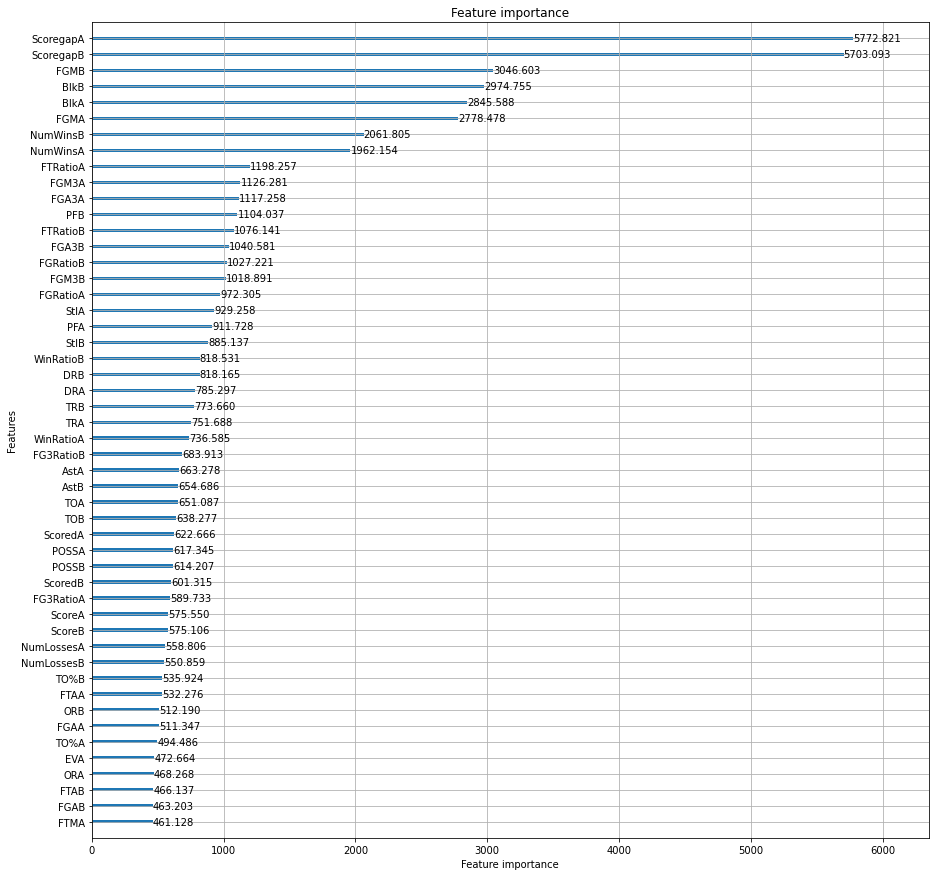

In [36]:
if TRAIN:
    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show();

### catboost

In [37]:
if CATBOOST:
    #  def train_catboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, cat_params, loss_func, calc_importances=False):
    seasons = tourney_results['Season'].unique()
    n = 13 # season 2016

    y_test_cat = []
    models_cat = []

    for season in seasons[n:]:
        print('valid_season{}'.format(season))
        train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
        valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

        train = train.sample(frac=1, random_state=SEED)
        x_train, y_train = train[features], train[target]
        x_val, y_val = valid[features], valid[target]

        if TRAIN:
            y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model_cat = \
                train_catboost(
                    x_train, y_train, x_val, y_val, test[features],
                    categorical_features = categorical_features,
                    fold_id = season,
                    cat_params = CAT_PARAMS,
                    loss_func = calc_loss
                )

            models_cat.append(model_cat)    
            #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

            y_test_cat.append(y_pred_test)

valid_season2016
valid_loss:  0.6287678237676422
get_best_iteration:  58
valid_season2017
valid_loss:  0.5029617974090865
get_best_iteration:  176
valid_season2018
valid_loss:  0.5533743662315788
get_best_iteration:  88
valid_season2019
valid_loss:  0.452826749707631
get_best_iteration:  250
valid_season2021
valid_loss:  0.5890754133762576
get_best_iteration:  137


In [38]:
if CATBOOST:
    print(valid_loss)

0.5890754133762576


### xgboost

In [39]:
if XGBOOST:
    #  def train_catboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, cat_params, loss_func, calc_importances=False):
    seasons = tourney_results['Season'].unique()
    n = 13 # season 2016

    y_test_xgb = []
    models_xgb = []

    for season in seasons[n:]:
        print('valid_season{}'.format(season))
        train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
        valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

        train = train.sample(frac=1, random_state=SEED)
        x_train, y_train = train[features], train[target]
        x_val, y_val = valid[features], valid[target]

        if TRAIN:
            y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model_xgb = \
                train_xgboost(
                    x_train, y_train, x_val, y_val, test[features],
                    categorical_features = categorical_features,
                    fold_id = season,
                    xgb_params = XGB_PARAMS,
                    fit_params = XGB_FIT_PARAMS,
                    loss_func = calc_loss
                )

            models_xgb.append(model_xgb)    
            #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

            y_test_xgb.append(y_pred_test)

valid_season2016
[0]	train-logloss:0.69235	val-logloss:0.69277
[100]	train-logloss:0.62576	val-logloss:0.66402
[200]	train-logloss:0.57630	val-logloss:0.65119
[300]	train-logloss:0.53715	val-logloss:0.64432
[400]	train-logloss:0.50584	val-logloss:0.64008
[500]	train-logloss:0.48050	val-logloss:0.63843
[537]	train-logloss:0.47218	val-logloss:0.64041
valid_loss:  0.6404105254581997
valid_season2017
[0]	train-logloss:0.69236	val-logloss:0.69256
[100]	train-logloss:0.62621	val-logloss:0.63909
[200]	train-logloss:0.57631	val-logloss:0.60344
[300]	train-logloss:0.53733	val-logloss:0.58019
[400]	train-logloss:0.50636	val-logloss:0.56734
[500]	train-logloss:0.48140	val-logloss:0.55648
[600]	train-logloss:0.46050	val-logloss:0.55140
[700]	train-logloss:0.44291	val-logloss:0.54848
[800]	train-logloss:0.42808	val-logloss:0.54534
[900]	train-logloss:0.41535	val-logloss:0.54207
[1000]	train-logloss:0.40461	val-logloss:0.53932
[1100]	train-logloss:0.39534	val-logloss:0.53634
[1200]	train-logloss:0.3

In [40]:
if XGBOOST:
    print(valid_loss)

0.5907229098772245


## Inference

In [41]:
# inference
y_test_sub =  np.mean(y_test,axis=0)

if ENSEMBLE == False:
    sub = pd.read_csv(SUB_PATH)
    sub["Pred"] = y_test_sub
    sub.to_csv(SAVE_TEST_SUB_PATH,index=False)
    sub.to_csv('submission.csv',index=False)
    print(sub.shape)    

#check
print(y_test_sub)
print(y_test_sub.shape)

[0.2529548  0.56938677 0.17248495 ... 0.43043903 0.79298407 0.85957091]
(10080,)


In [42]:
if CATBOOST:
    # inference cat
    y_test_sub_cat =  np.mean(y_test_cat,axis=0)
    #check
    print(y_test_sub_cat)
    print(y_test_sub_cat.shape)

[0.27535492 0.56700537 0.25041603 ... 0.43722665 0.75615646 0.81412783]
(10080,)


In [43]:
if XGBOOST:
    # inference xgb
    y_test_sub_xgb =  np.mean(y_test_xgb, axis=0)
    #check
    print(y_test_sub_xgb)
    print(y_test_sub_xgb.shape)

[0.2394721  0.5481788  0.18337217 ... 0.40569806 0.7887372  0.88838226]
(10080,)


In [44]:
if ENSEMBLE:
    sub = pd.read_csv(SUB_PATH)
#     sub['Pred'] = 0.5*y_test_sub +  0.5*y_test_sub_xgb #+ 0.2*y_test_sub_cat
    sub['Pred'] = y_test_sub_xgb #+ 0.2*y_test_sub_cat
    
    sub.to_csv(SAVE_TEST_SUB_PATH,index=False)
    sub.to_csv('submission.csv',index=False)
    print(sub.shape)

(10080, 2)


In [45]:
! ls

__notebook__.ipynb  catboost_info  exp001_submission.csv  submission.csv
